In this notebook mental health (P-Factor) ECRS are computed. Predictive performances are compared accross several models (XGBoost, Random Forest and LASSO) and finally Shapley values are extracted from the final ECRS to get local explanations.

# Data loading

In [1]:
# autoreload python file
%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import sys
import json
import copy
import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_selection import SelectFwe, SelectFromModel, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from scipy import stats
import optuna
import pickle
from datetime import date

# custom imports
import os
import sys
path = os.getcwd()
parent = os.path.dirname(path)
sys.path.append(parent)
from utils import fit_regr_skmodel, covariates_2steps_target_adjustement_cv, plot_dashboard, plot_shap_dashboard, get_lasso_feature_selection, compute_lasso_feature_selection, get_display_feature_mapping, fit_2step_regr_skmodel, fit_2s
from utils import extract_significant_interactions, plot_dependance_plots
from utils import delete_unwanted_covariates, extract_selected_features, adjust_sample_size_to_outcome, compute_covariates_variance_explained
from utils import compute_family_shap
from utils import cohorts_cv, covariates_2steps_target_adjustement_cohort_cv

In [2]:
# load codebook, one hot column list
codebook = pd.read_excel('../../../data/Helix data codebook.xlsx', na_values='NA')
selection = 'selection_mental'
with open('../../../data/imputed/mapping/one_hot_columns.json', 'r') as f:
    one_hot_columns = json.load(f)

In [3]:
# load health outcomes
health_outcomes = pd.read_csv("../../../data/outcomes/outcomes.csv").set_index("HelixID", drop=True, verify_integrity=True)
target_col = "GPF" # pfactor
print(health_outcomes.shape)

(1622, 3)


In [4]:
# Load imputed data
imputed_df = pd.read_csv("../../../data/imputed/mf_all_no_prs.csv").set_index('HelixID', drop=True, verify_integrity=True)
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, BIB10041 to SAB99
Columns: 478 entries, hs_zbmi_who to hs_nutr_supp_1.0
dtypes: float64(404), int64(74)
memory usage: 5.6+ MB


In [5]:
# delete unwanted variables
features = extract_selected_features(codebook, imputed_df, selection, one_hot_columns)

selected continuous covariates: ['h_mbmi', 'hs_child_age_days', 'h_age']
selected_categorical_covariates ['h_edumc', 'h_edufc', 'h_native', 'h_parity', 'seabir', 'cohort']
Dropped 2 covariates: ['e3_gac', 'hs_wgtgain']
Dropped 0 prs: []
Dropped 0 clinical factors: []


In [6]:
features, target = adjust_sample_size_to_outcome(features, health_outcomes[target_col])

Total number of missing values: 7
Using a feature dataframe of 1520 rows
Target column got 1615 non missing values
Adjusting sample size...
DF shape after merge: (1520, 477)
DF shape after droping NaNs (1513, 477)


In [7]:
fs_covariates = ["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0']

In [8]:
metabolites = []
proteins = []
covariates = []
clinical_markers = []
exposures = []

not_selected = []

skip_list = []
for col in features.columns:
    if col.endswith(".0"):
        col = col[:-4]
        if col in skip_list:
            continue
        skip_list.append(col)
    if codebook['selected'].loc[codebook['variable_name'] == col].iloc[0] != 1:
        not_selected.append(col)
    if codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Serum metabolome' or codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Urine metabolome':
        metabolites.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Proteome':
        proteins.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Covariates':
        covariates.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (cardio)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (mental)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Parental clinical factors (mental)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (respi)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Lipids' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Parental clinical factors':
            clinical_markers.append(col)
    else:
        exposures.append(col)

print("Number of metabolites:", len(metabolites))
print("Number of proteins:", len(proteins))
print("Number of covariates:", len(covariates))
print("Number of clinical markers:", len(clinical_markers))
print("Number of exposures:", len(exposures))
print(not_selected)

Number of metabolites: 78
Number of proteins: 34
Number of covariates: 10
Number of clinical markers: 20
Number of exposures: 303
[]


In [9]:
# Use sqrt transformation to get normally distributed outcome.
transformed_target = np.sqrt(target + np.abs(np.min(target)))

mean: 0.003349631055504447 ~ std: 0.9776548699615029


<AxesSubplot:>

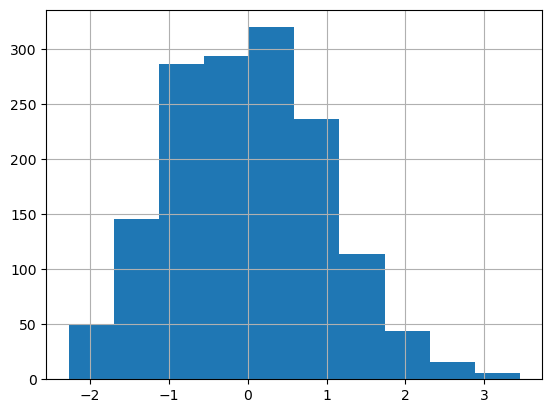

In [10]:
# standardize target
transformed_target = (transformed_target - transformed_target.mean())/transformed_target.std()
print("mean:", target.mean(), "~ std:", target.std())
transformed_target.hist()

In [11]:
stats.kstest(transformed_target, 'norm')

KstestResult(statistic=0.03271355271630405, pvalue=0.07673691863755627)

# Hyperparameters tuning

In [13]:
# XGBoost tuning
def objective(trial, X, y):
    cohort_cols = ['cohort_1.0', 'cohort_2.0', 'cohort_3.0', 'cohort_4.0', 'cohort_5.0']
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 450),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.001),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.001),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0, step=0.001),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0, step=0.001),
        # 'gamma': trial.suggest_float('gamma', 0.0, 5.0, step=0.01),
        'seed': 42,
        # 'tree_method': 'hist',  # for faster computation
    }
    
    # 10-fold CV
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Cohort adjustment on training split
        # xgb_cohort = XGBRegressor(learning_rate=0.1,
        #                n_estimators=50,
        #                max_depth=1,
        #                objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 0)
        xgb_cohort = XGBRegressor(learning_rate=0.1,
                       n_estimators=140,
                       max_depth=2,
                       # gamma=1,
                       objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 0)
        xgb_cohort.fit(X_train[cohort_cols], y_train)
        residuals_train = y_train - xgb_cohort.predict(X_train[cohort_cols])
        
        # Train final model on residuals
        model = XGBRegressor(**params)
        model.fit(X_train.drop(columns=cohort_cols), residuals_train)
        
        # Cohort adjustment on validation split
        residuals_val = y_val - xgb_cohort.predict(X_val[cohort_cols])
        
        # Predict on validation split
        preds = model.predict(X_val.drop(columns=cohort_cols))
        scores.append(r2_score(residuals_val, preds))

    # Return the average MSE
    return sum(scores) / len(scores)

In [14]:
# create new study
# name = f"xgb_2s_10f_cv {date.today()}"
# study_final = optuna.create_study(direction='maximize', study_name=name)

In [15]:
# load existing study
name = f"xgb_2s_10f_cv 2023-10-17"
with open(f"./optuna_trials/{name}.pkl", 'rb') as f:
    study_final = pickle.load(f)

In [222]:
# optimize HP
try:
    study_final.optimize(lambda trial: objective(trial, features, transformed_target))
except KeyboardInterrupt:
    print("KeyboardInterrupt detected. Saving the study...")
    with open(f"./optuna_trials/{name}.pkl", 'wb') as f:
        pickle.dump(study_final, f)
    print("Study saved.")

[I 2023-10-22 10:48:03,807] Trial 8164 finished with value: 0.11307546074201866 and parameters: {'n_estimators': 263, 'max_depth': 2, 'min_child_weight': 5, 'learning_rate': 0.03025379706234795, 'subsample': 0.641, 'colsample_bytree': 0.881, 'reg_alpha': 1.08, 'reg_lambda': 9.478, 'gamma': 3.39}. Best is trial 4997 with value: 0.1261312698147281.
[I 2023-10-22 10:48:25,685] Trial 8165 finished with value: 0.11220480840814026 and parameters: {'n_estimators': 405, 'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.025059510607193067, 'subsample': 0.718, 'colsample_bytree': 0.858, 'reg_alpha': 0.328, 'reg_lambda': 8.274000000000001, 'gamma': 3.92}. Best is trial 4997 with value: 0.1261312698147281.
[I 2023-10-22 10:48:40,960] Trial 8166 finished with value: 0.11652671064678403 and parameters: {'n_estimators': 353, 'max_depth': 2, 'min_child_weight': 13, 'learning_rate': 0.01864928822993087, 'subsample': 0.733, 'colsample_bytree': 0.8400000000000001, 'reg_alpha': 0.665, 'reg_lambda'

KeyboardInterrupt detected. Saving the study...
Study saved.


In [16]:
# Best hyperparameters
best_params = study_final.best_params
best_params['seed'] = 42
print("Best params are:", best_params , "with R2:", study_final.best_value)

Best params are: {'n_estimators': 382, 'max_depth': 2, 'min_child_weight': 1, 'learning_rate': 0.024045744937260694, 'subsample': 0.725, 'colsample_bytree': 0.839, 'reg_alpha': 0.3, 'reg_lambda': 7.577, 'seed': 42} with R2: 0.1261312698147281


In [17]:
assert(objective(study_final.best_trial, features, transformed_target) == study_final.best_value) # Sanity test

### Random forest

In [48]:
# RF tuning
def objective_rf(trial, X, y):
    cohort_cols = ['cohort_1.0', 'cohort_2.0', 'cohort_3.0', 'cohort_4.0', 'cohort_5.0']
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 150),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 75),
        'max_depth': trial.suggest_int('max_depth', 1, 14),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0, step=0.01),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'random_state': 42,
        # 'tree_method': 'hist',  # for faster computation
    }
    
    # 10-fold CV
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Cohort adjustment on training split
        rf_cohort = RandomForestRegressor(n_estimators = 100,
                               # criterion="absolute_error",
                               min_samples_leaf = 90,
                               max_leaf_nodes = 8,
                               max_depth=5,
                               random_state = 454)
        rf_cohort.fit(X_train[cohort_cols], y_train)
        residuals_train = y_train - rf_cohort.predict(X_train[cohort_cols])
        
        # Train final model on residuals
        model = RandomForestRegressor(**params)
        model.fit(X_train.drop(columns=cohort_cols), residuals_train)
        
        # Cohort adjustment on validation split
        residuals_val = y_val - rf_cohort.predict(X_val[cohort_cols])
        
        # Predict on validation split
        preds = model.predict(X_val.drop(columns=cohort_cols))
        scores.append(r2_score(residuals_val, preds))

    # Return the average MSE
    return sum(scores) / len(scores)

In [49]:
# create new study
# name = f"RF_2s_10f_cv {date.today()}"
# study_rf = optuna.create_study(direction='maximize', study_name=name)

In [50]:
# load existing study
name = "RF_2s_10f_cv 2023-10-22"
with open(f"./optuna_trials/{name}.pkl", 'rb') as f:
    study_rf = pickle.load(f)

In [284]:
# optimize HP
try:
    study_rf.optimize(lambda trial: objective_rf(trial, features, transformed_target))
except KeyboardInterrupt:
    print("KeyboardInterrupt detected. Saving the study...")
    with open(f"./optuna_trials/{name}.pkl", 'wb') as f:
        pickle.dump(study_rf, f)
    print("Study saved.")

[I 2023-10-24 10:29:45,094] Trial 236 finished with value: 0.10485169367338083 and parameters: {'n_estimators': 130, 'min_samples_leaf': 8, 'max_leaf_nodes': 46, 'max_depth': 12, 'max_features': 0.81, 'min_samples_split': 28}. Best is trial 199 with value: 0.10809028858433875.
[I 2023-10-24 10:32:02,433] Trial 237 finished with value: 0.10432058679388867 and parameters: {'n_estimators': 117, 'min_samples_leaf': 8, 'max_leaf_nodes': 46, 'max_depth': 12, 'max_features': 0.81, 'min_samples_split': 28}. Best is trial 199 with value: 0.10809028858433875.
[I 2023-10-24 10:34:10,534] Trial 238 finished with value: 0.09825480419291825 and parameters: {'n_estimators': 117, 'min_samples_leaf': 13, 'max_leaf_nodes': 46, 'max_depth': 12, 'max_features': 0.81, 'min_samples_split': 27}. Best is trial 199 with value: 0.10809028858433875.
[I 2023-10-24 10:36:32,959] Trial 239 finished with value: 0.09669584566750114 and parameters: {'n_estimators': 122, 'min_samples_leaf': 9, 'max_leaf_nodes': 43, 'ma

KeyboardInterrupt detected. Saving the study...
Study saved.


In [51]:
# Best hyperparameters
rf_best_params = study_rf.best_params
rf_best_params['random_state'] = 42
print("Best params are:", rf_best_params , "with R2:", study_rf.best_value)

Best params are: {'n_estimators': 158, 'min_samples_leaf': 4, 'max_leaf_nodes': 61, 'max_depth': 13, 'max_features': 0.84, 'min_samples_split': 20, 'random_state': 42} with R2: 0.10809028858433875


# Cross validation performances

1. linear regressions.

In [18]:
# lasso
lr_cov = LinearRegression()
lasso_risk = Lasso(selection='random', alpha=0.02, random_state=42)
lasso_test_scores = covariates_2steps_target_adjustement_cv(cov_model=lr_cov,
                                                            res_model=lasso_risk,
                                                            covariate_list=fs_covariates,
                                                            features=features,
                                                            target=transformed_target,
                                                            standardize=True,
                                                            verbose=False, save_results=True,
                                                            show_residual_plots=False, show_residual_histograms=False)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 10, means: 0.00198453745337457
Results:
	step 1 mean train score: 0.154 std:0.01
	step 1 mean test score: 0.137 std:0.06
	step 2 mean train score: 0.301 std:0.01
	step 2 mean test score: 0.120 std:0.07
	final mean train score: 0.409 std:0.01
	final mean test score: 0.245 std:0.10


Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 10, means: 0.00198453745337457


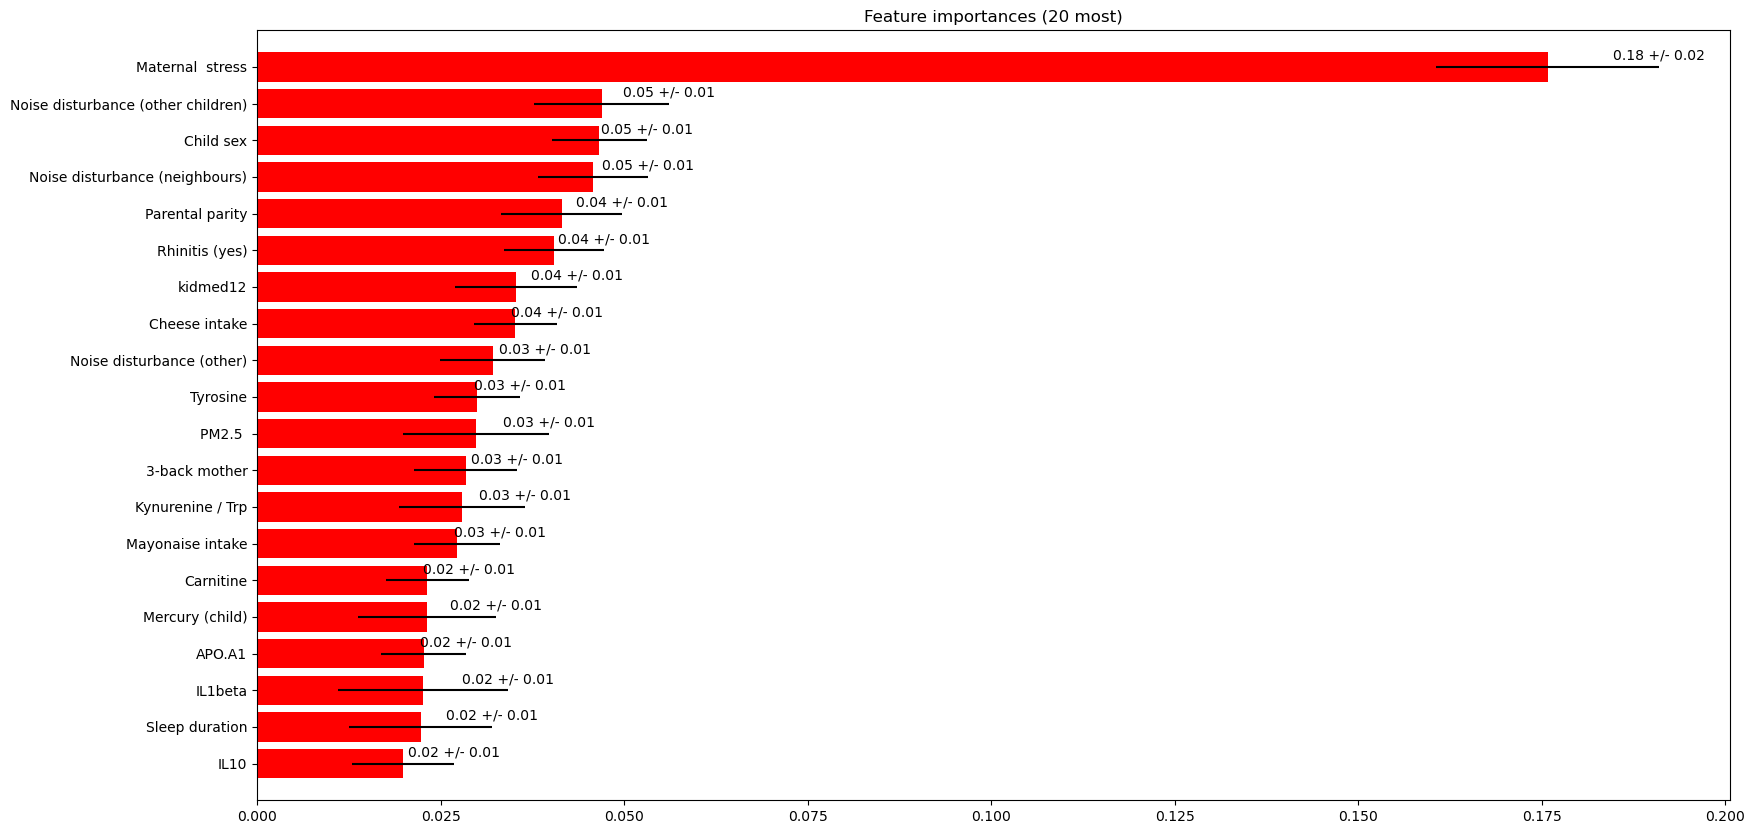

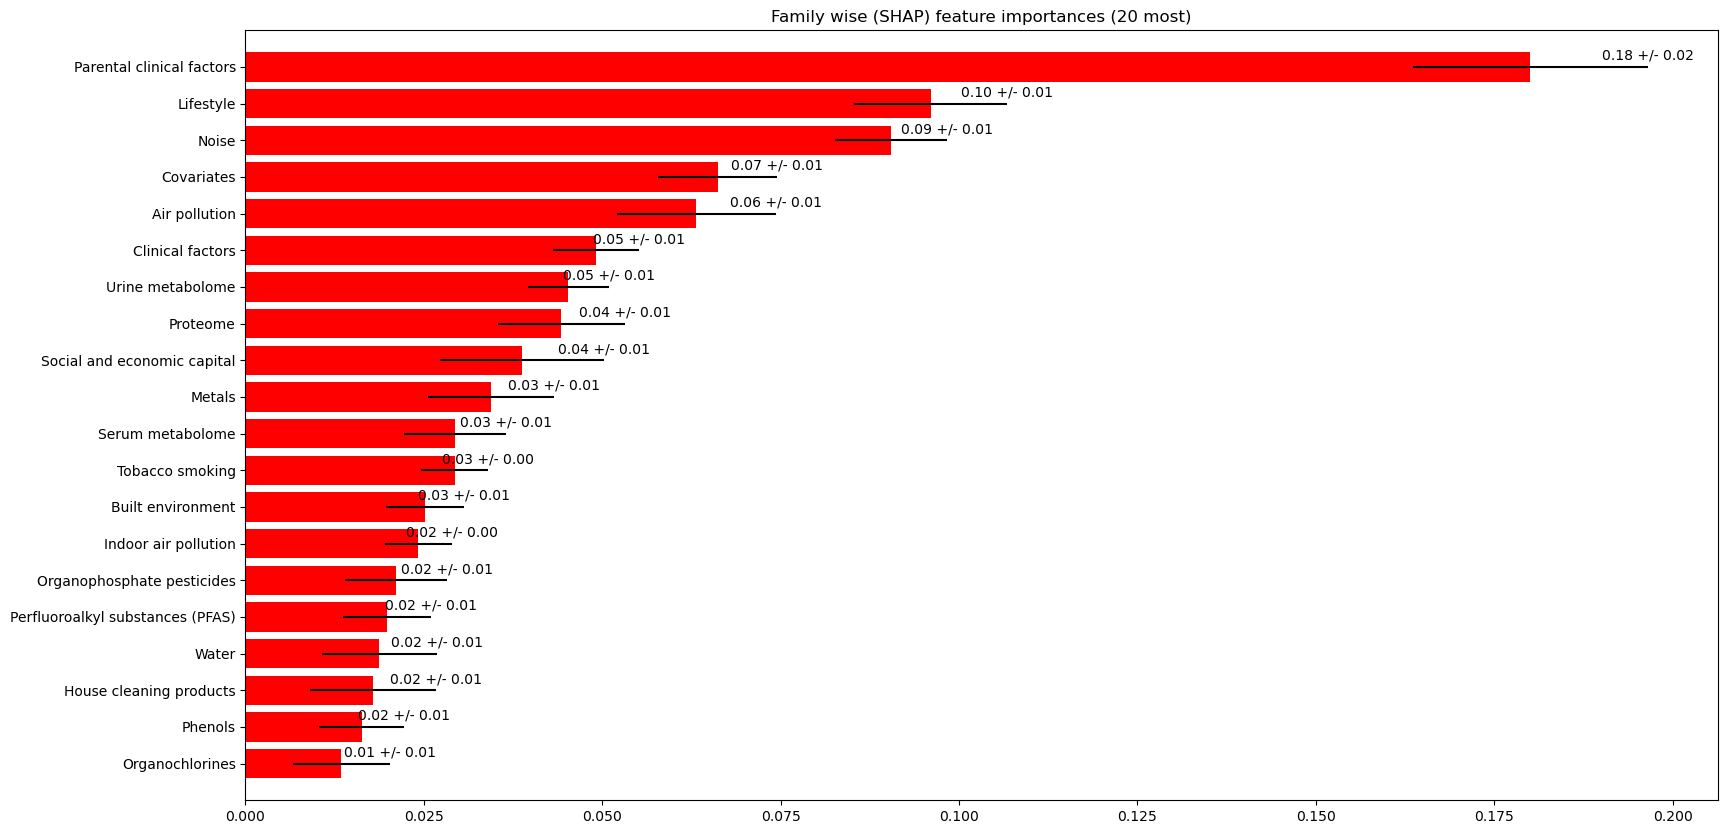

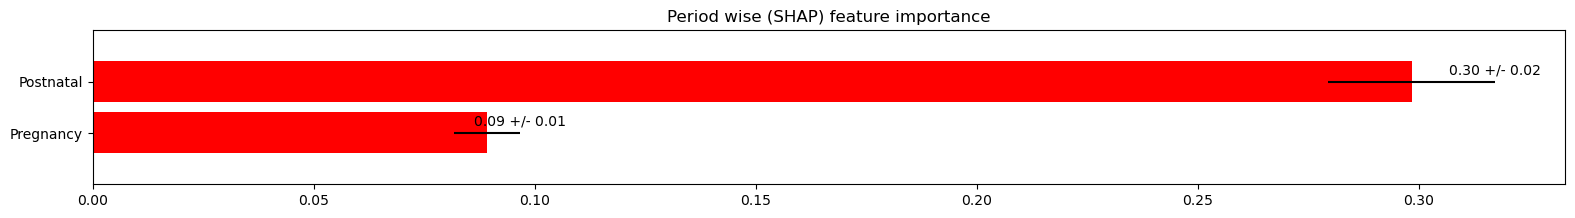

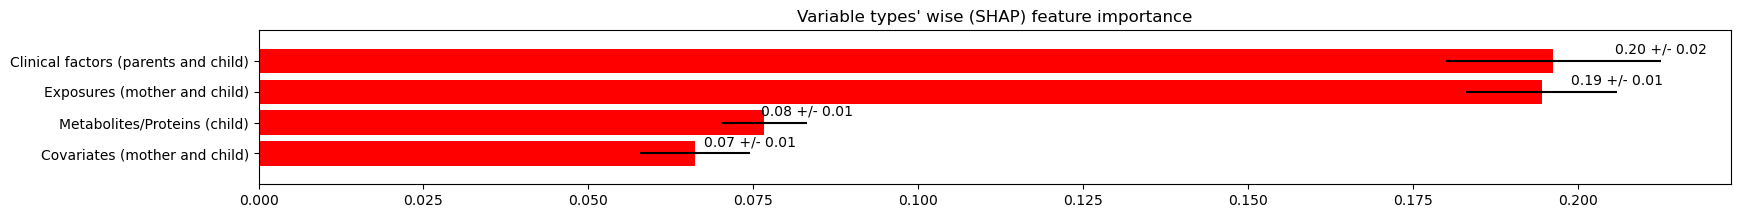

In [19]:
# Compute shapley values and plot aggregated feature contributions
_ = covariates_2steps_target_adjustement_cv(cov_model=lr_cov,
                                            res_model=lasso_risk,
                                            covariate_list=fs_covariates,
                                            features=features,
                                            target=transformed_target,
                                            standardize=True,
                                            feature_selection_reg=None,
                                            verbose=False, save_results=False,
                                            feature_importance='shap')

2. random forests

In [52]:
# without feature selection
rf_cov = RandomForestRegressor(n_estimators = 100,
                               # criterion="absolute_error",
                               min_samples_leaf = 90,
                               max_leaf_nodes = 8,
                               max_depth=5,
                               random_state = 42)
# rf_risk = RandomForestRegressor(n_estimators = 300, random_state = 42)
rf_risk = RandomForestRegressor(**rf_best_params)
_ = covariates_2steps_target_adjustement_cv(cov_model=rf_cov,
                                        res_model=rf_risk,
                                        covariate_list=fs_covariates,
                                        features=features,
                                        target=transformed_target,
                                        standardize=False,
                                        verbose=False, save_results=True)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 9, means: 0.000360761337334458
Results:
	step 1 mean train score: 0.154 std:0.01
	step 1 mean test score: 0.137 std:0.06
	step 2 mean train score: 0.644 std:0.00
	step 2 mean test score: 0.106 std:0.04
	final mean train score: 0.698 std:0.00
	final mean test score: 0.235 std:0.06


3. xgboost

In [20]:
xgb_cohort = XGBRegressor(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=2,
                          # gamma=1,
                          objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 0)
xgb_risk = XGBRegressor(**best_params)

xgb_test_scores = covariates_2steps_target_adjustement_cv(cov_model=xgb_cohort,
                                        res_model=xgb_risk,
                                        covariate_list=fs_covariates,
                                        features=features,
                                        target=transformed_target,
                                        standardize=False,
                                        feature_selection_reg=None,
                                        verbose=False, save_results=True)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 9, means: 0.0022599233431255033
Results:
	step 1 mean train score: 0.152 std:0.01
	step 1 mean test score: 0.136 std:0.06
	step 2 mean train score: 0.412 std:0.00
	step 2 mean test score: 0.126 std:0.04
	final mean train score: 0.502 std:0.00
	final mean test score: 0.251 std:0.06


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 9, means: 0.0022599233431255033


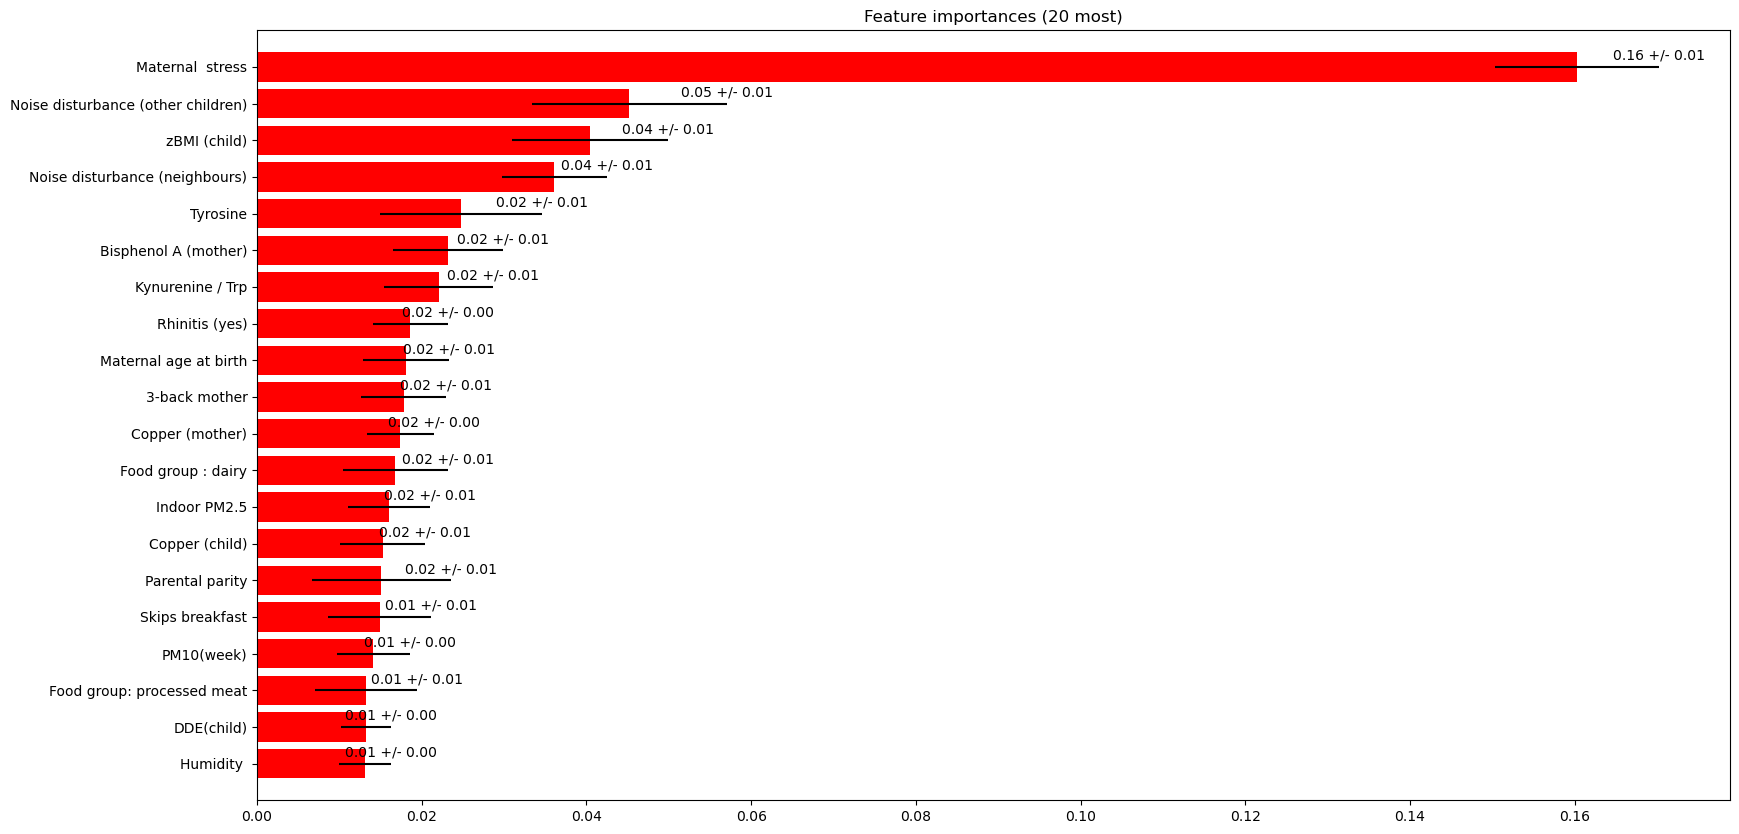

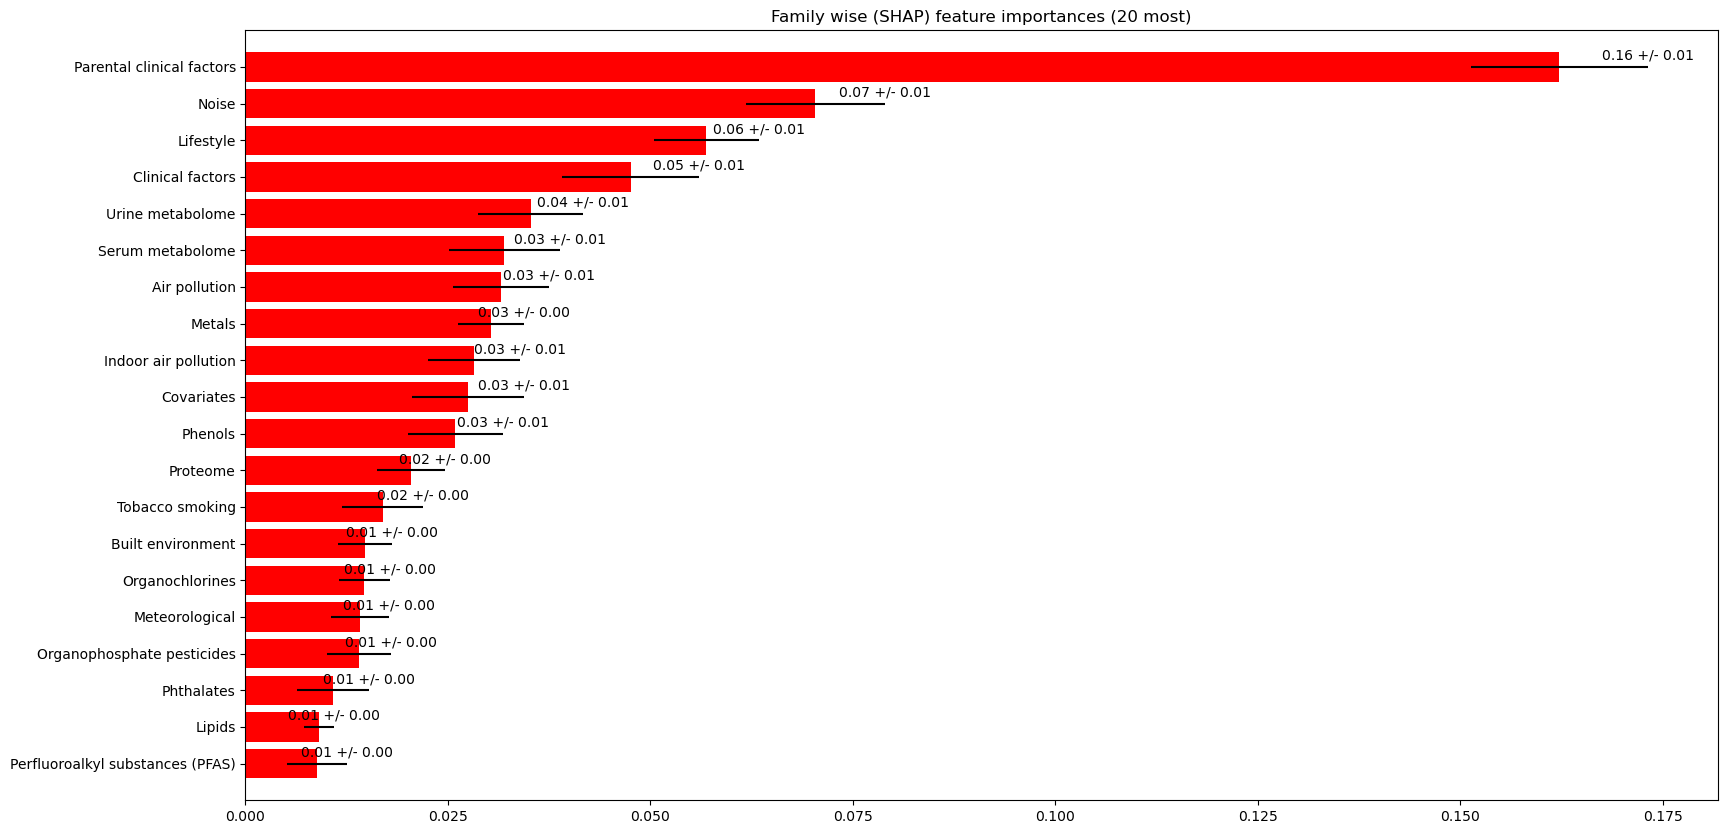

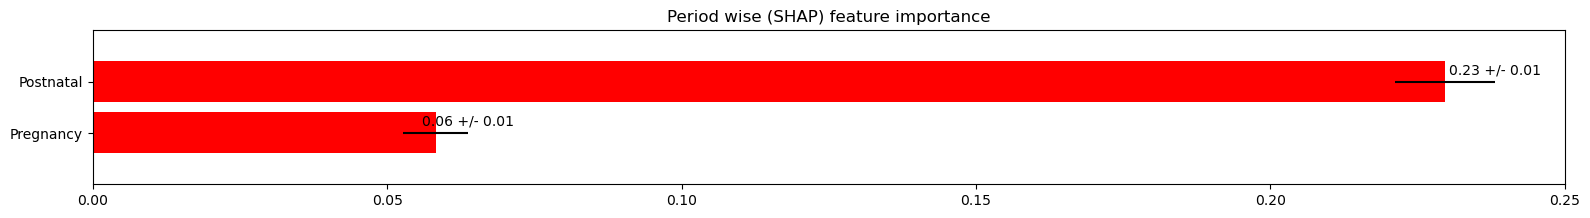

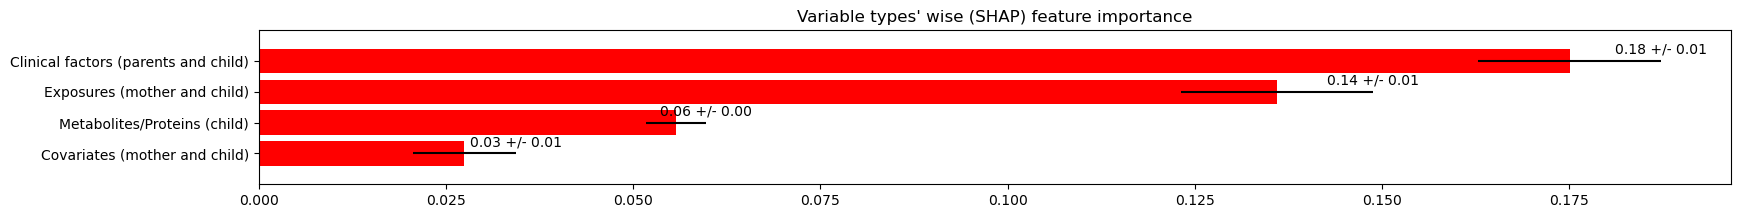

In [21]:
_ = covariates_2steps_target_adjustement_cv(cov_model=xgb_cohort,
                                            res_model=xgb_risk,
                                            covariate_list=fs_covariates,
                                            features=features,
                                            target=transformed_target,
                                            standardize=False,
                                            feature_selection_reg=None,
                                            verbose=False, save_results=True,
                                            feature_importance='shap')

In [24]:
# compare XGB performances with LASSO
from scipy.stats import wilcoxon
from scipy import stats
res = wilcoxon(lasso_test_scores, xgb_test_scores)
print(res.statistic, res.pvalue)
stats.ttest_rel(xgb_test_scores, lasso_test_scores)

24.0 0.76953125


Ttest_relResult(statistic=0.41801292821109115, pvalue=0.6857347228333635)

# Local explanations

step1 r2: 0.152 - step2 r2: 0.393 - final r2: 0.485


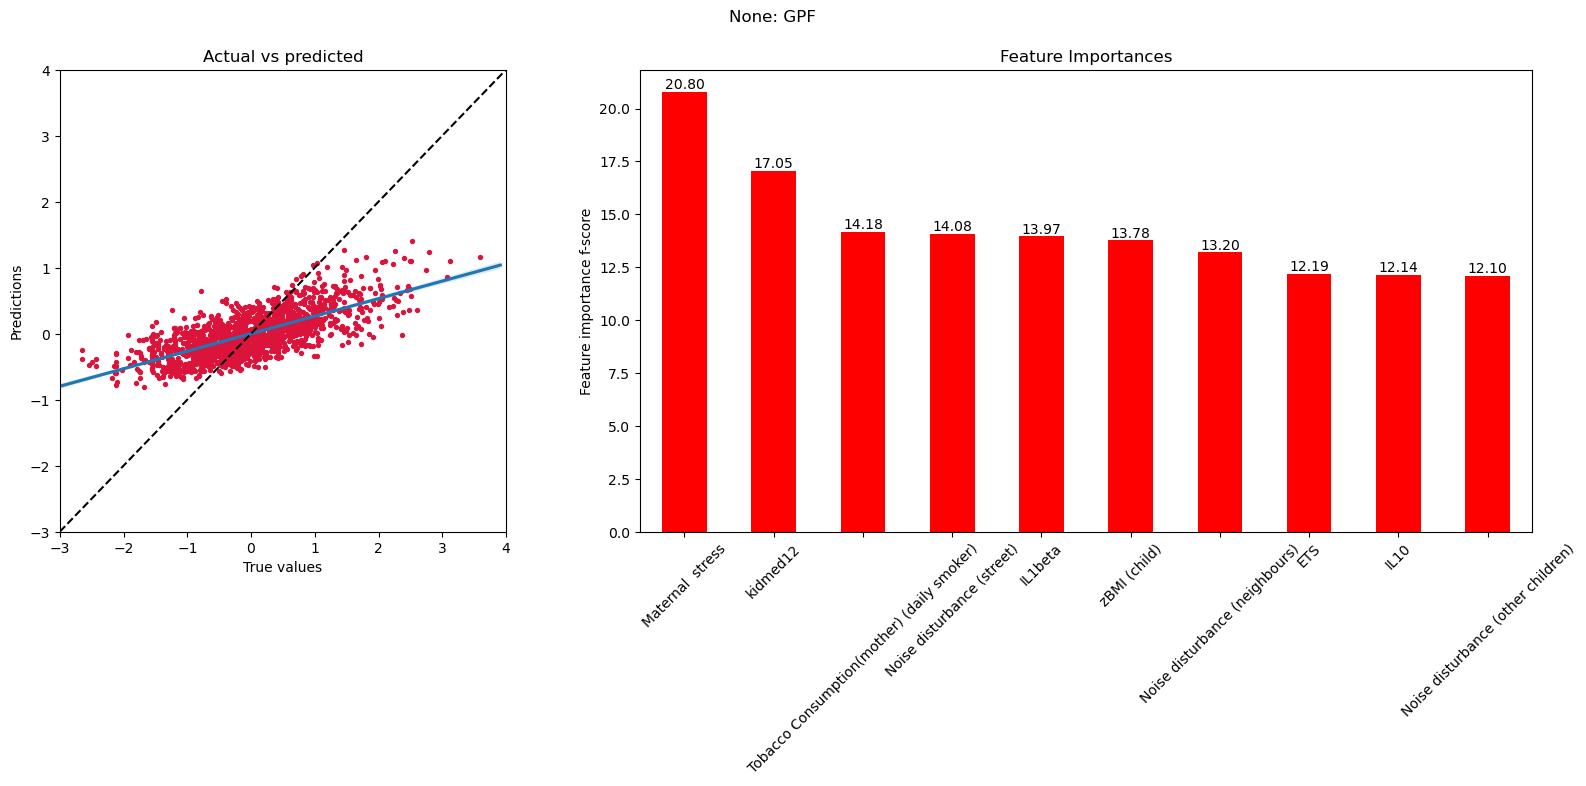

In [25]:
# Try without train/test split : model is trained on the entire dataset.
xgb_cov = XGBRegressor(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=2,
                          # gamma=1,
                          objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 0)
xgb_res = XGBRegressor(**best_params)

predicted_risk = fit_2s(xgb_cov, xgb_res, covariates=fs_covariates, features=features, target=transformed_target, selected_features=None, standardize=False, verbose=True)
predicted_risk = pd.DataFrame(predicted_risk, index=features.index, columns=['ERS_mental'])
predicted_risk.to_csv("./../../../results/ERS/mental.csv")

step1 r2: 0.153 - step2 r2: 0.266 - final r2: 0.378


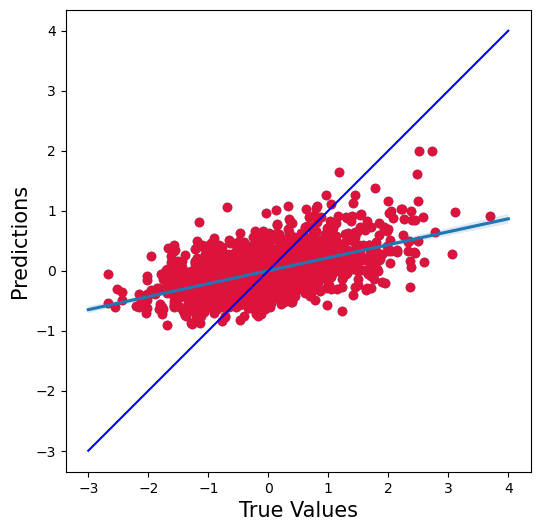

In [26]:
# Fit LASSO on the entire dataset.
# class CustomLasso(Lasso):
#     def __init__(self, alpha, selection='random', random_state=42):
#         super().__init__(alpha=0.02, selection=selection, random_state=42)
        
#     def __standardize(self, X):
#         cat_variables = []
#         for var in X.columns:
#             if var.endswith(".0"):
#                 cat_variables.append(var)
#         # cat_variables = [f"cohort_{i}.0" for i in range(1, 6)]
#         scaler = StandardScaler()
#         std_X = scaler.fit_transform(X)
#         std_X = pd.DataFrame(data=std_X, columns=[ele for ele in X.columns], index=X.index)
#         std_X[cat_variables] = X[cat_variables]
#         return std_X
        
#     def fit(self, X, y):
#         X = self.__standardize(X)
#         super().fit(X, y)
#         return self
        
#     def predict(self, X):
#         X = self.__standardize(X)
#         return super().predict(X)

# std features
cat_variables = []
for var in features.columns:
    if var.endswith(".0"):
        cat_variables.append(var)
scaler = StandardScaler()
std_X = scaler.fit_transform(features)
std_X = pd.DataFrame(data=std_X, columns=[ele for ele in features.columns], index=features.index)
std_X[cat_variables] = features[cat_variables]
std_features = std_X

std_features 
lr_cov = LinearRegression()
lasso_res = Lasso(selection='random', alpha=0.02, random_state=42)

predicted_risk = fit_2s(lr_cov, lasso_res, covariates=fs_covariates, features=std_features, target=transformed_target, selected_features=None, standardize=False, verbose=True)
predicted_risk = pd.DataFrame(predicted_risk, index=features.index, columns=['ERS_mental'])
predicted_risk.to_csv("./../../../results/ERS/mental_lasso.csv")

In [27]:
# compute shapley values
import shap
explainer = shap.TreeExplainer(xgb_res,
                               feature_perturbation='tree_path_dependent') # 'interventional' requires to provides a background dataset.
# without feat. selection
updated_feature_selection = features.drop(["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0'], axis=1, errors="ignore").columns
shap_values = explainer(features[updated_feature_selection])

# get display_names
mapping_featurename_x_displayname = get_display_feature_mapping(shap_values.feature_names)
display_names = [mapping_featurename_x_displayname[key] for key in shap_values.feature_names]
display_shap = copy.deepcopy(shap_values)
display_shap.feature_names = display_names

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


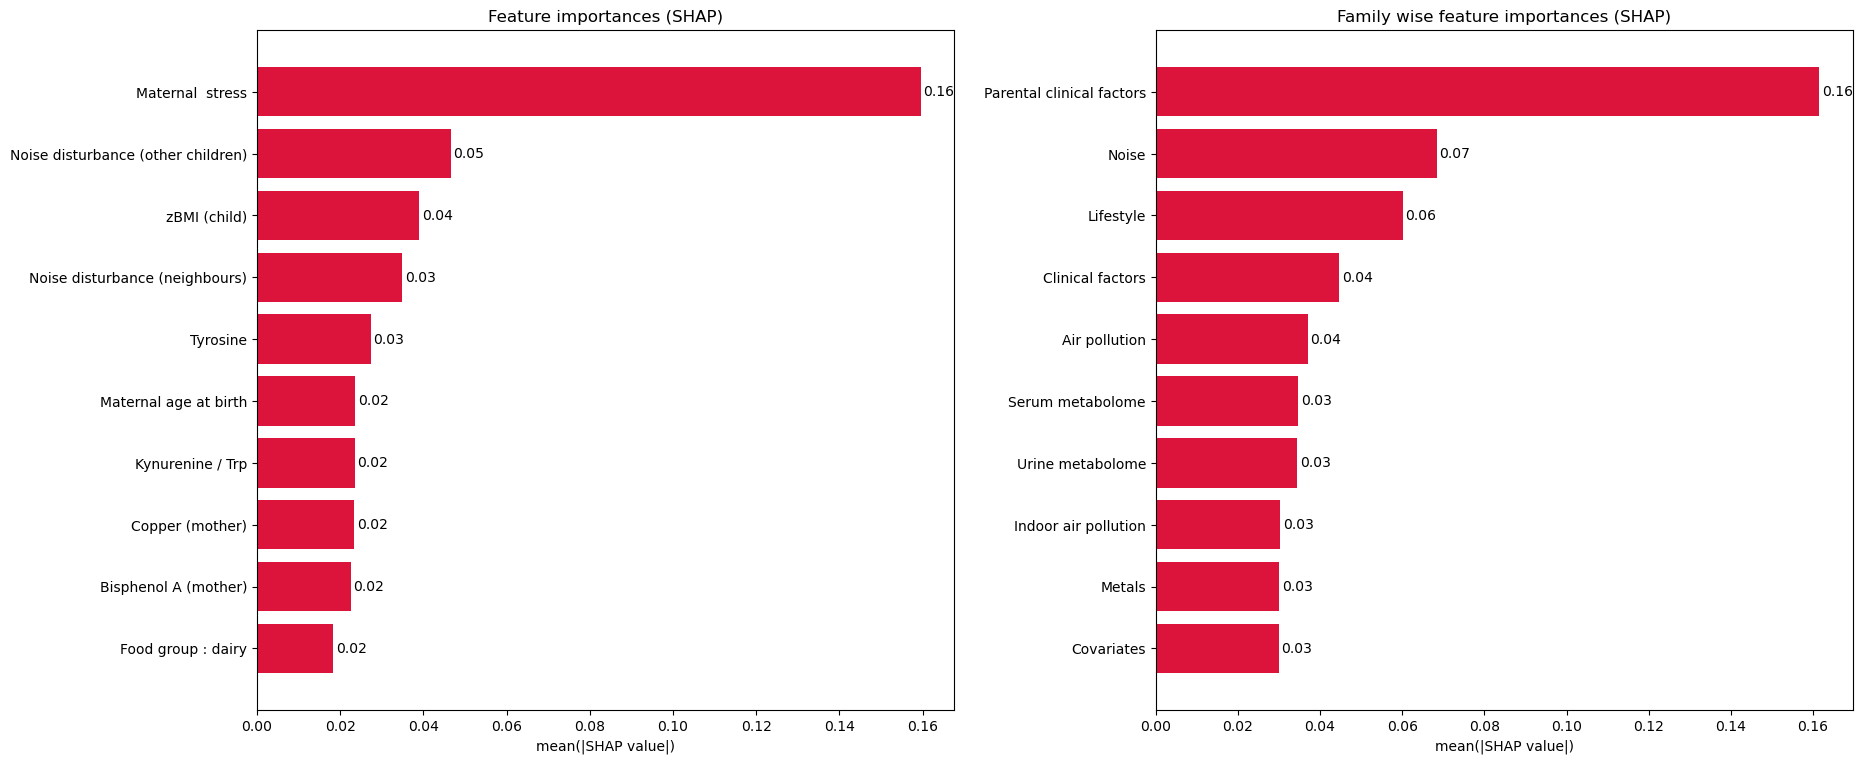

In [28]:
plot_shap_dashboard(shap_values, figsize=(19, 8))

In [29]:
# compute LASSO shapley values
import shap
updated_feature_selection = features.drop(["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0'], axis=1, errors="ignore").columns
Lasso_explainer = shap.LinearExplainer(lasso_res, features[updated_feature_selection])
lasso_shap_values = Lasso_explainer(features[updated_feature_selection])

# get display_names
lasso_mapping_featurename_x_displayname = get_display_feature_mapping(lasso_shap_values.feature_names)
lasso_display_names = [lasso_mapping_featurename_x_displayname[key] for key in lasso_shap_values.feature_names]
# print(lasso_display_names)
# print(lasso_shap_values.feature_names)
lasso_display_shap = copy.deepcopy(lasso_shap_values)
lasso_display_shap.feature_names = lasso_display_names
lasso_display_shap.data = features.values # use original feature space
# plot_shap_dashboard(lasso_display_shap, figsize=(19, 8))

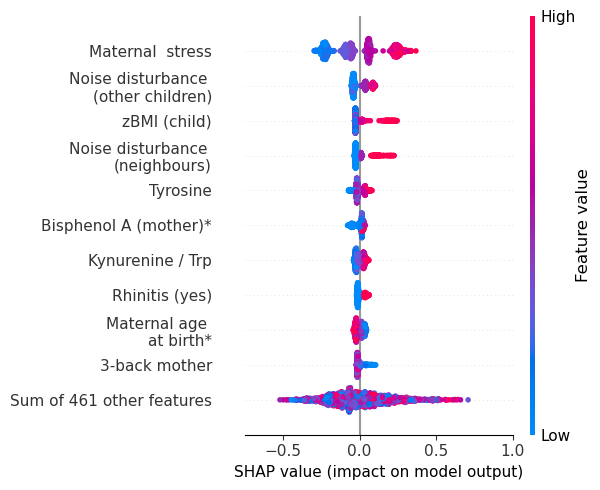

In [30]:
# display SHAP beeswarm plot
import matplotlib.pyplot as plt
from utils import get_oh_x_orig_mapping

display_cpy = copy.deepcopy(display_shap)
number_of_features = 10

# use feature importance order obtained with cross validation.
fis = pd.read_excel('./../../../data/results/2steps_fi.xlsx').sort_values(['GPF mean feature importance'], ascending=False)
fis_order = list(fis['exposure'])[:number_of_features]
col2num = {col: i for i, col in enumerate(display_cpy.feature_names)}
order = list(map(col2num.get, fis_order)) 
padding = []
for i in range(len(display_cpy.feature_names)):
    if i not in order:
        padding.append(i)
order = order + padding

for i, feature in enumerate(display_cpy.feature_names):
    if len(feature) > 20:
        s = feature.split(" ")
        if len(s) > 1:
            ind = (len(s)+1)//2
            last = s[ind]
            s[ind] = '\n' + last
            display_cpy.feature_names[i] = " ".join(s)

codebook = pd.read_excel('./../../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'name_for_table', 'period']].set_index('variable_name')
mapping = get_oh_x_orig_mapping(list(shap_values.feature_names))
for i in range(0, len(list(shap_values.feature_names))):
    try:
        idx = codebook.loc[list(shap_values.feature_names)[i]]
    except KeyError:
        idx = codebook.loc[mapping[list(shap_values.feature_names)[i]]]
    if idx['period'] == 'Pregnancy':
        # print(list(display_cpy.feature_names)[i])
        display_cpy.feature_names[i] = list(display_cpy.feature_names)[i] + '*'
        # print("DEBUG: added * to:", labels[i])


shap.plots.beeswarm(display_cpy, max_display=number_of_features+1, order=order, show=False, color_bar=True)
# plt.title('P-factor', fontdict={'fontsize': 10, 'fontweight' : 'bold'})
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 5)
ax.xaxis.label.set_size(11)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.xlim([-0.75, 1])
fig.tight_layout()
# plt.tight_layout()
plt.savefig('./../../../data/results/images/pfac_local_exp.png')
plt.show()

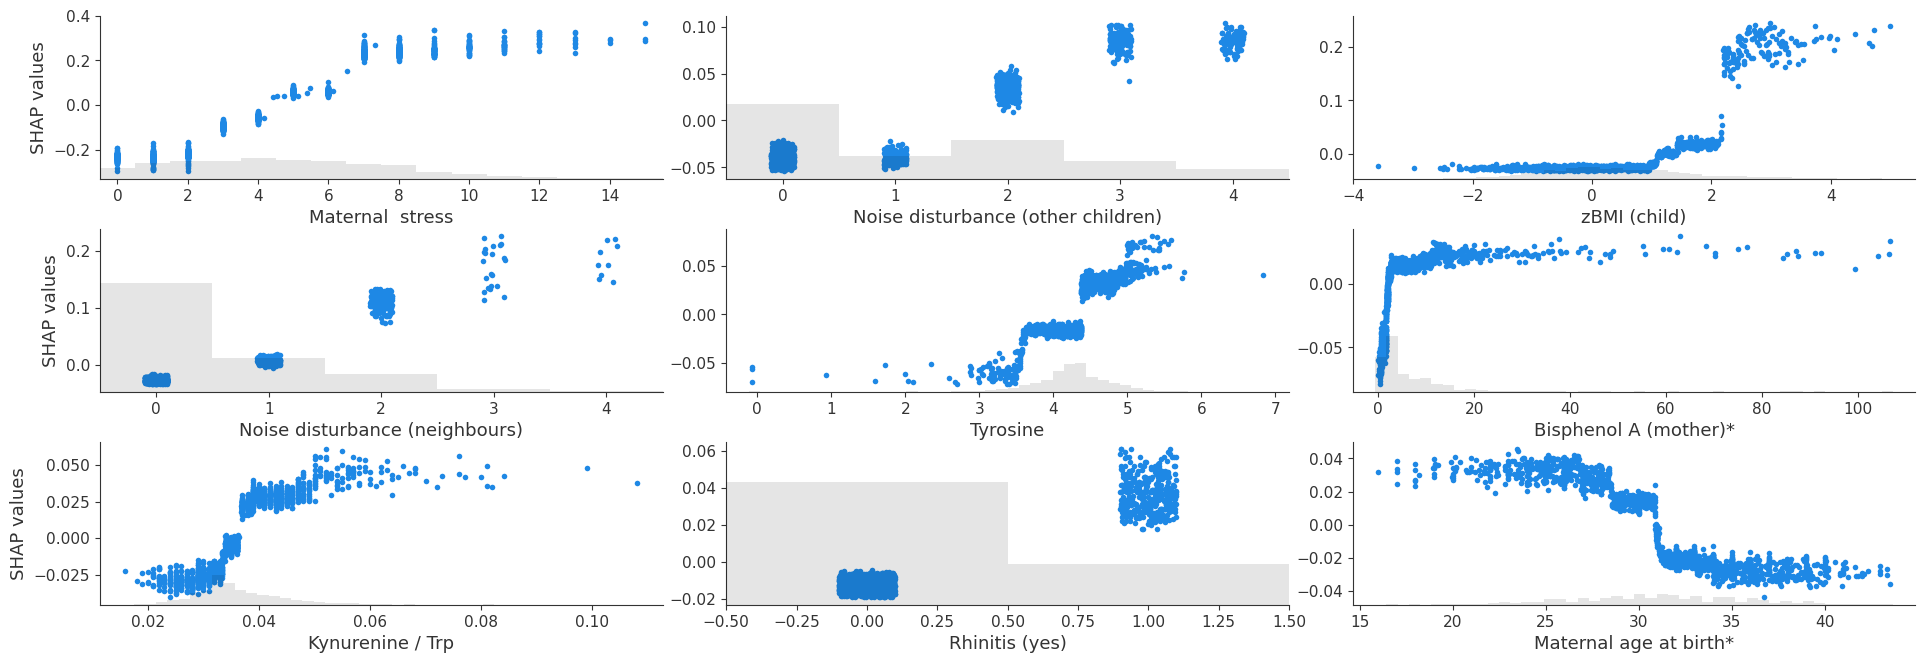

In [31]:
# remove  "\n" characters from names
for i, feature in enumerate(display_cpy.feature_names):
    display_cpy.feature_names[i] = display_cpy.feature_names[i].replace("\n","")

# diplays dependance plots
n_col, n_lin = 3, 3
fig, axes = plt.subplots(n_lin, n_col, figsize=(19, n_lin * 2.2), gridspec_kw={"width_ratios" : [1, 1, 1]}, sharey=False)
# fig.suptitle("P-factor", fontsize=14, fontweight='bold')
fig.tight_layout(pad=1.5)
for l in range(0,n_lin):
    for c in range(0, n_col):
        shap.plots.scatter(display_cpy[:, order[l * n_col + c]], ax=axes[l, c], show=False)
        if c == 0:
            axes[l, c].set_ylabel("SHAP values")
        else:
            axes[l, c].set_ylabel("")
plt.savefig('./../../../data/results/pfac_dependance_plots.png', bbox_inches="tight")
plt.show()

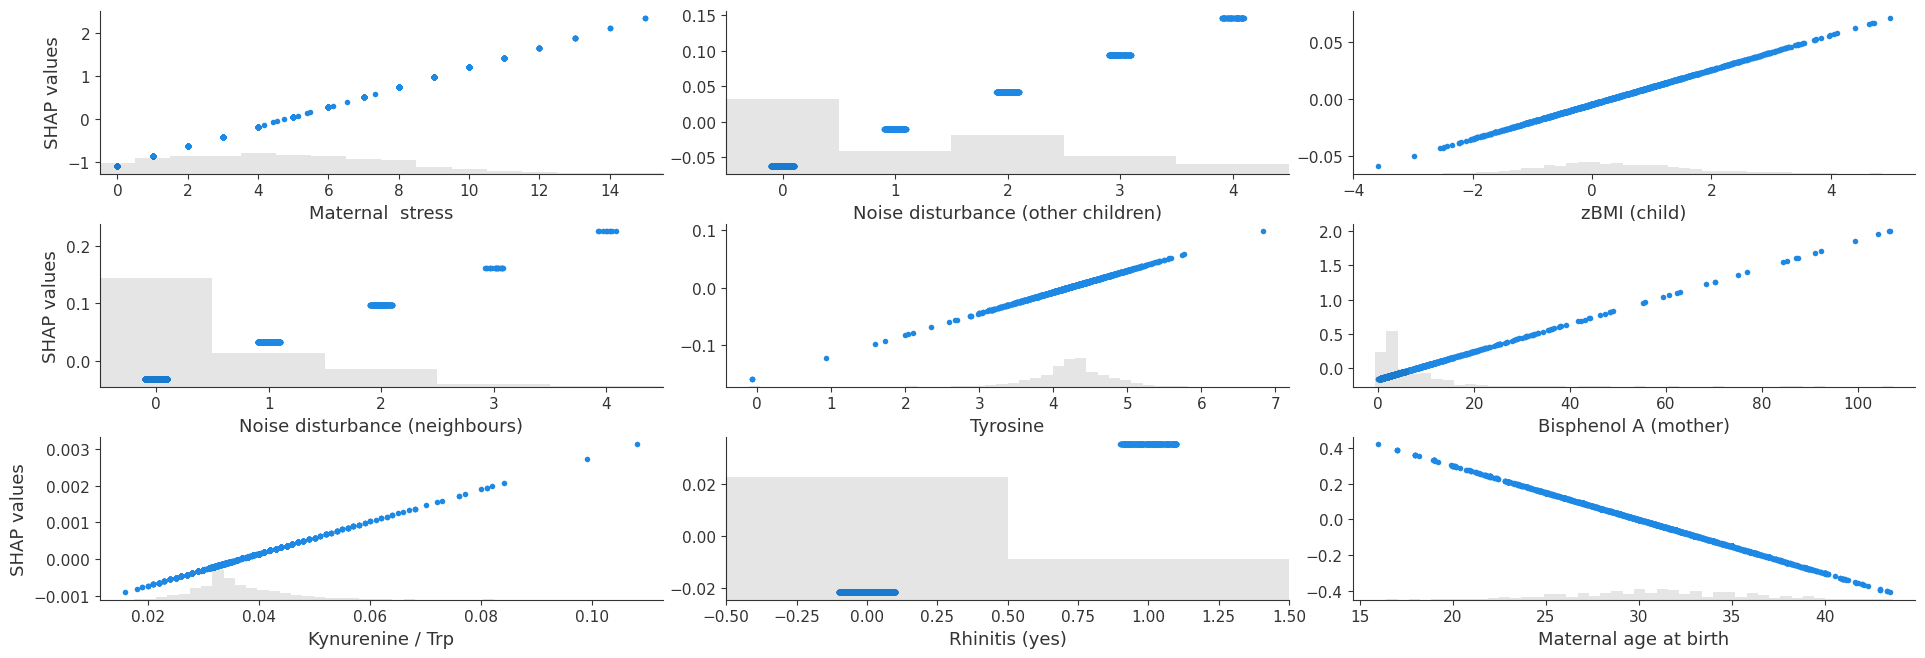

In [32]:
# remove  "\n" characters from names
for i, feature in enumerate(display_cpy.feature_names):
    display_cpy.feature_names[i] = display_cpy.feature_names[i].replace("\n","")

# diplays dependance plots
n_col, n_lin = 3, 3
fig, axes = plt.subplots(n_lin, n_col, figsize=(19, n_lin * 2.2), gridspec_kw={"width_ratios" : [1, 1, 1]}, sharey=False)
# fig.suptitle("P-factor", fontsize=14, fontweight='bold')
fig.tight_layout(pad=1.5)
for l in range(0,n_lin):
    for c in range(0, n_col):
        shap.plots.scatter(lasso_display_shap[:, order[l * n_col + c]], ax=axes[l, c], show=False)
        if c == 0:
            axes[l, c].set_ylabel("SHAP values")
        else:
            axes[l, c].set_ylabel("")
plt.savefig('./../../../data/results/pfac_dependance_plots_lasso.png', bbox_inches="tight")
plt.show()

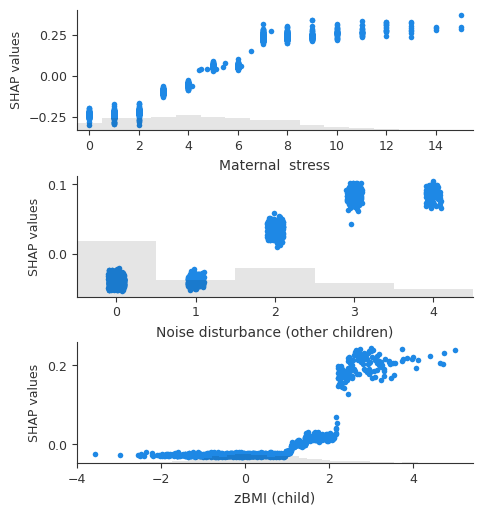

In [33]:
# Column wise dependance plots for figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 5), gridspec_kw={"width_ratios" : [1]}, sharey=False)
# fig.suptitle("Lung function", fontsize=14, fontweight='bold')
shap.plots.scatter(display_cpy[:, order[0]], ax=ax1, show=False)
shap.plots.scatter(display_cpy[:, order[1]], ax=ax2, show=False)
shap.plots.scatter(display_cpy[:, order[2]], ax=ax3, show=False)
fontsize=10
ax1.xaxis.get_label().set_fontsize(fontsize)
ax2.xaxis.get_label().set_fontsize(fontsize)
ax3.xaxis.get_label().set_fontsize(fontsize)
fig.tight_layout(pad=0.1)
# ax2.xticks(fontsize=14, rotation=90)
for tick in ax1.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax1.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax2.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax2.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax3.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax3.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
ax1.set_ylabel("SHAP values", fontsize=9)
ax2.set_ylabel("SHAP values", fontsize=9)
ax3.set_ylabel("SHAP values", fontsize=9)
plt.savefig('./../../../data/results/pfac_col_dependance_plots.png', bbox_inches="tight")
plt.show()

In [34]:
# compute pairwise interactions
shap_interaction = explainer.shap_interaction_values(features[updated_feature_selection])
print(shap_interaction.shape)

(1513, 471, 471)


In [39]:
# plot pairwise importances according to mean SHAP values
significant_interactions = extract_significant_interactions(shap_interactions=shap_interaction, feature_names=updated_feature_selection, percent=10, threshold=0.002, mode='mean')
# plot_dependance_plots(shap_interactions=shap_interaction, features=features, feature_names=updated_feature_selection, significant_interactions=significant_interactions[:10], title="P-Factor pairwise interactions")

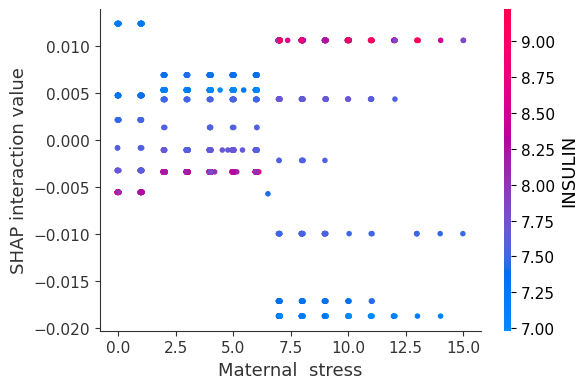

In [40]:
# plot particular interaction for figure
plot_dependance_plots(shap_interactions=shap_interaction, features=features, feature_names=updated_feature_selection, significant_interactions=[significant_interactions[1]], title="P-Factor chosen interactions")

In [41]:
# Compute marginal and interaction effects size
tmp = np.abs(shap_interaction).mean(0)
interaction_strengths_dict = {}
marginal_effect_dict = {}
for i in range(tmp.shape[0]):
    for j in range(i, tmp.shape[1]):
        if tmp[i, j] > 0:
            f1 = updated_feature_selection[i]
            f2 = updated_feature_selection[j]
            key = f1 + '_XXX_' + f2
            if f1==f2:
                marginal_effect_dict[f1] = tmp[i, j]
            else:
                interaction_strengths_dict[key] = 2 * tmp[i, j] # interaction(x1<=>x2) = interaction(x1.x2) + interaction(x2.x1)

marginal_effect_dict = {k: v for k, v in sorted(marginal_effect_dict.items(), key=lambda item: item[1], reverse=True)} # sort by value    
interaction_strengths_dict = {k: v for k, v in sorted(interaction_strengths_dict.items(), key=lambda item: item[1], reverse=True)} # sort by value                
          
print(len(marginal_effect_dict))
print(len(interaction_strengths_dict))

279
622


In [42]:
# print top n mean interaction effects size
for key in list(interaction_strengths_dict.keys())[:10]:
    print(key, ':', interaction_strengths_dict[key])

PSS_4_Score_XXX_hs_rhin_ly_1.0 : 0.00668993080034852
PSS_4_Score_XXX_INSULIN : 0.00644873920828104
PSS_4_Score_XXX_hs_dairy : 0.005990151781588793
PSS_4_Score_XXX_X.C2.C3....C0 : 0.005338037386536598
hs_m_dnumeros3_XXX_Total.SM.OH...Total.SM.non.OH : 0.004554974380880594
hs_cu_m_XXX_hs_green_dist_h : 0.004360825289040804
PSS_4_Score_XXX_hs_noi_othchild : 0.0037235268391668797
PSS_4_Score_XXX_h_age : 0.0034667213913053274
hs_m_dnumeros3_XXX_h_parity : 0.0034236996434628963
hs_Absorbance_XXX_hs_skipbreakf : 0.0032502575777471066


In [43]:
print("marginal effets (mean shapley values):", np.mean(list(marginal_effect_dict.values())[0:10]))
print("interaction effects (mean shapley values):", np.mean(list(interaction_strengths_dict.values())[0:10]))
print("ratio:", np.mean(list(marginal_effect_dict.values())[0:10]) / np.mean(list(interaction_strengths_dict.values())[0:10]))

marginal effets (mean shapley values): 0.0415807
interaction effects (mean shapley values): 0.004724686429835856
ratio: 8.800732070097842


# Cohorts CV

In [44]:
transformed_features = features.copy(deep=True)
transformed_features['cohort_6.0'] = (transformed_features[fs_covariates].sum(axis=1) == 0).astype(int)

In [312]:
lr_cov = LinearRegression()
lasso_risk = Lasso(selection='random', alpha=0.02, random_state=1)

covariates_2steps_target_adjustement_cohort_cv(cov_model=lr_cov,
                                               res_model=lasso_risk,
                                               features=transformed_features,
                                               target=transformed_target,
                                               standardize=True)

Results:
	step 1 mean train score: 0.146 std:0.05
	step 1 mean test score: -21561747028047753457434624.000 std:34032543754969358754906112.00
	step 2 mean train score: 0.316 std:0.01
	step 2 mean test score: -21561851705947030462398464.000 std:34032730354693094380666880.00
	final mean train score: 0.416 std:0.03
	final mean test score: -21561747028048105644752896.000 std:34032543754969771071766528.00
Complete results
	step 1 mean train scores: [0.15917659426603914, 0.15002010916544095, 0.04513395179172075, 0.15909122001557274, 0.19720596032929505, 0.16744122176449394]
	step 1 mean test score: [-9.682476388779181e+25, -3.145982000925339e+24, -1.5931294731085481e+25, -9.453877345164628e+24, -3.139845521160837e+24, -8.74718682158416e+23]
	step 2 mean train score: [0.30652180610705904, 0.30699499842163, 0.3342336761960094, 0.32288148056210764, 0.3206821685831134, 0.30192062238407413]
	step 2 mean test score: [-9.682529271815634e+25, -3.1459987400937115e+24, -1.5931209246700666e+25, -9.45406

**Standardize per cohorts**

In [46]:
# Get the original cohort values from the one-hot encoded columns
cohorts = transformed_features.filter(like="cohort_").idxmax(axis=1).str.replace("cohort_", "").astype(float).astype(int)
# print(cohorts)

# Function to standardize a series
def standardize(series):
    return (series - series.mean()) / series.std()

# Create copies to store standardized values
standardized_features = transformed_features.copy()
standardized_target = transformed_target.copy()

# Standardize features and target per cohort
for cohort, indices in cohorts.groupby(cohorts).groups.items():
    features_subset = standardized_features.loc[indices]
    for feature_col in features_subset.columns.difference(cohorts.index):  # Only non-cohort columns
        standardized_features.loc[indices, feature_col] = standardize(features_subset[feature_col])
    standardized_target.loc[indices] = standardize(target[indices])

# standardized_features = standardized_features.dropna(axis=1, how='all')
cohorts = [f"cohort_{i}.0" for i in range(1, 7)]
standardized_features[cohorts] = transformed_features[cohorts]
# print(standardized_features.isna().sum())
# display(standardized_features.head())
# print(standardized_target)

In [47]:
xgb_risk = XGBRegressor(**best_params)
xgb_test_scores = covariates_2steps_target_adjustement_cohort_cv(cov_model=xgb_cov, 
                                                                 res_model=xgb_risk,
                                                                 features=standardized_features,
                                                                 target=standardized_target,
                                                                 standardize=False)

Results:
	step 1 mean train score: -0.000 std:0.00
	step 1 mean test score: -0.000 std:0.00
	step 2 mean train score: 0.468 std:0.01
	step 2 mean test score: 0.134 std:0.04
	final mean train score: 0.468 std:0.01
	final mean test score: 0.134 std:0.04
Complete results
	step 1 mean train scores: [-3.863576125695545e-14, -3.863576125695545e-14, -3.8413716652030416e-14, -3.8413716652030416e-14, -3.863576125695545e-14, -3.863576125695545e-14]
	step 1 mean test score: [-3.863576125695545e-14, -3.907985046680551e-14, -3.8413716652030416e-14, -3.8413716652030416e-14, -3.863576125695545e-14, -3.863576125695545e-14]
	step 2 mean train score: [0.45457046171280924, 0.463029511259631, 0.4852457074409414, 0.45744324133944114, 0.4908474234625376, 0.45470899337830384]
	step 2 mean test score: [0.1694237821671012, 0.11774003537406341, 0.0628251875440694, 0.15478061574104962, 0.1327158548820221, 0.16749203697059856]
	final mean train score: [0.4545704637863611, 0.4630295133205897, 0.48524571049295606, 